## 在图数据库上构建一个问答应用

In [1]:
# 导入必要的模块
import getpass
import os

# 检查并设置OpenAI API密钥
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

# 可选：启用LangSmith追踪
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
# os.environ["LANGSMITH_TRACING"] = "true"

# 设置Neo4j数据库连接信息
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "password"



In [2]:
# 设置Neo4j数据库连接参数
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "hefeng6500"

In [5]:
# 导入Neo4j图数据库模块
from langchain_neo4j import Neo4jGraph

# 创建Neo4j图数据库连接
graph = Neo4jGraph()

# 导入电影信息

movies_query = """
LOAD CSV WITH HEADERS FROM 
'https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/movies/movies_small.csv'
AS row
MERGE (m:Movie {id:row.movieId})
SET m.released = date(row.released),
    m.title = row.title,
    m.imdbRating = toFloat(row.imdbRating)
FOREACH (director in split(row.director, '|') | 
    MERGE (p:Person {name:trim(director)})
    MERGE (p)-[:DIRECTED]->(m))
FOREACH (actor in split(row.actors, '|') | 
    MERGE (p:Person {name:trim(actor)})
    MERGE (p)-[:ACTED_IN]->(m))
FOREACH (genre in split(row.genres, '|') | 
    MERGE (g:Genre {name:trim(genre)})
    MERGE (m)-[:IN_GENRE]->(g))
"""

# 执行查询导入电影数据
graph.query(movies_query)

[]

In [6]:
# 刷新图数据库模式
graph.refresh_schema()
# 打印图数据库模式信息
print(graph.schema)

Node properties:
Movie {imdbRating: FLOAT, id: STRING, released: DATE, title: STRING}
Person {name: STRING}
Genre {name: STRING}
Relationship properties:

The relationships:
(:Movie)-[:IN_GENRE]->(:Genre)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:ACTED_IN]->(:Movie)


In [7]:
# 创建带有增强模式的Neo4j图数据库连接
enhanced_graph = Neo4jGraph(enhanced_schema=True)
# 打印增强模式的图数据库信息
print(enhanced_graph.schema)

Node properties:
- **Movie**
  - `imdbRating`: FLOAT Min: 2.4, Max: 9.3
  - `id`: STRING Example: "1"
  - `released`: DATE Min: 1964-12-16, Max: 1996-09-15
  - `title`: STRING Example: "Toy Story"
- **Person**
  - `name`: STRING Example: "John Lasseter"
- **Genre**
  - `name`: STRING Example: "Adventure"
Relationship properties:

The relationships:
(:Movie)-[:IN_GENRE]->(:Genre)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:ACTED_IN]->(:Movie)


In [8]:
# 导入图Cypher问答链和OpenAI聊天模型
from langchain_neo4j import GraphCypherQAChain
from langchain_openai import ChatOpenAI

# 初始化LLM模型
llm = ChatOpenAI(model="gpt-4o", temperature=0)
# 创建图Cypher问答链
chain = GraphCypherQAChain.from_llm(
    graph=enhanced_graph, llm=llm, verbose=True, allow_dangerous_requests=True
)
# 执行查询：询问Casino电影的演员阵容
response = chain.invoke({"query": "What was the cast of the Casino?"})
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Person)-[:ACTED_IN]->(m:Movie {title: "Casino"})
RETURN p.name AS cast

Full Context:
[{'cast': 'James Woods'}, {'cast': 'Joe Pesci'}, {'cast': 'Robert De Niro'}, {'cast': 'Sharon Stone'}]

> Finished chain.


{'query': 'What was the cast of the Casino?',
 'result': 'James Woods, Joe Pesci, Robert De Niro, Sharon Stone were the cast of Casino.'}

## 使用 LangGraph 的高级实现

In [9]:
# 导入必要的类型注解和操作符
from operator import add
from typing import Annotated, List

from typing_extensions import TypedDict


# 定义输入状态类型
class InputState(TypedDict):
    question: str


# 定义整体状态类型，包含问题处理的各个阶段信息
class OverallState(TypedDict):
    question: str
    next_action: str
    cypher_statement: str
    cypher_errors: List[str]
    database_records: List[dict]
    steps: Annotated[List[str], add]


# 定义输出状态类型
class OutputState(TypedDict):
    answer: str
    steps: List[str]
    cypher_statement: str

In [10]:
# 导入类型注解和相关模块
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# 定义护栏系统提示词，用于判断问题是否与电影相关
guardrails_system = """
As an intelligent assistant, your primary objective is to decide whether a given question is related to movies or not. 
If the question is related to movies, output "movie". Otherwise, output "end".
To make this decision, assess the content of the question and determine if it refers to any movie, actor, director, film industry, 
or related topics. Provide only the specified output: "movie" or "end".
"""
# 创建护栏提示模板
guardrails_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            guardrails_system,
        ),
        (
            "human",
            ("{question}"),
        ),
    ]
)


# 定义护栏输出模型
class GuardrailsOutput(BaseModel):
    decision: Literal["movie", "end"] = Field(
        description="Decision on whether the question is related to movies"
    )


# 创建护栏处理链
guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)


def guardrails(state: InputState) -> OverallState:
    """
    判断问题是否与电影相关的护栏函数
    """
    guardrails_output = guardrails_chain.invoke({"question": state.get("question")})
    database_records = None
    if guardrails_output.decision == "end":
        database_records = "This questions is not about movies or their cast. Therefore I cannot answer this question."
    return {
        "next_action": guardrails_output.decision,
        "database_records": database_records,
        "steps": ["guardrail"],
    }

In [11]:
# 导入语义相似性示例选择器和相关模块
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_neo4j import Neo4jVector
from langchain_openai import OpenAIEmbeddings

# 定义示例问题和对应的Cypher查询
examples = [
    {
        "question": "How many artists are there?",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie) RETURN count(DISTINCT a)",
    },
    {
        "question": "Which actors played in the movie Casino?",
        "query": "MATCH (m:Movie {title: 'Casino'})<-[:ACTED_IN]-(a) RETURN a.name",
    },
    {
        "question": "How many movies has Tom Hanks acted in?",
        "query": "MATCH (a:Person {name: 'Tom Hanks'})-[:ACTED_IN]->(m:Movie) RETURN count(m)",
    },
    {
        "question": "List all the genres of the movie Schindler's List",
        "query": "MATCH (m:Movie {title: 'Schindler's List'})-[:IN_GENRE]->(g:Genre) RETURN g.name",
    },
    {
        "question": "Which actors have worked in movies from both the comedy and action genres?",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g1:Genre), (a)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g2:Genre) WHERE g1.name = 'Comedy' AND g2.name = 'Action' RETURN DISTINCT a.name",
    },
    {
        "question": "Which directors have made movies with at least three different actors named 'John'?",
        "query": "MATCH (d:Person)-[:DIRECTED]->(m:Movie)<-[:ACTED_IN]-(a:Person) WHERE a.name STARTS WITH 'John' WITH d, COUNT(DISTINCT a) AS JohnsCount WHERE JohnsCount >= 3 RETURN d.name",
    },
    {
        "question": "Identify movies where directors also played a role in the film.",
        "query": "MATCH (p:Person)-[:DIRECTED]->(m:Movie), (p)-[:ACTED_IN]->(m) RETURN m.title, p.name",
    },
    {
        "question": "Find the actor with the highest number of movies in the database.",
        "query": "MATCH (a:Actor)-[:ACTED_IN]->(m:Movie) RETURN a.name, COUNT(m) AS movieCount ORDER BY movieCount DESC LIMIT 1",
    },
]

# 创建基于语义相似性的示例选择器
example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples, OpenAIEmbeddings(), Neo4jVector, k=5, input_keys=["question"]
)

In [12]:
# 导入字符串输出解析器
from langchain_core.output_parsers import StrOutputParser

# 创建文本转Cypher查询的提示模板
text2cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "Given an input question, convert it to a Cypher query. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.
Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!
Here is the schema information
{schema}

Below are a number of examples of questions and their corresponding Cypher queries.

{fewshot_examples}

User input: {question}
Cypher query:"""
            ),
        ),
    ]
)

# 创建文本转Cypher查询的处理链
text2cypher_chain = text2cypher_prompt | llm | StrOutputParser()


def generate_cypher(state: OverallState) -> OverallState:
    """
    基于提供的模式和用户输入生成Cypher语句
    """
    NL = "\n"
    fewshot_examples = (NL * 2).join(
        [
            f"Question: {el['question']}{NL}Cypher:{el['query']}"
            for el in example_selector.select_examples(
                {"question": state.get("question")}
            )
        ]
    )
    generated_cypher = text2cypher_chain.invoke(
        {
            "question": state.get("question"),
            "fewshot_examples": fewshot_examples,
            "schema": enhanced_graph.schema,
        }
    )
    return {"cypher_statement": generated_cypher, "steps": ["generate_cypher"]}

In [13]:
# 导入类型注解
from typing import List, Optional

# 定义Cypher验证系统提示词
validate_cypher_system = """
You are a Cypher expert reviewing a statement written by a junior developer.
"""

# 定义Cypher验证用户提示词
validate_cypher_user = """You must check the following:
* Are there any syntax errors in the Cypher statement?
* Are there any missing or undefined variables in the Cypher statement?
* Are any node labels missing from the schema?
* Are any relationship types missing from the schema?
* Are any of the properties not included in the schema?
* Does the Cypher statement include enough information to answer the question?

Examples of good errors:
* Label (:Foo) does not exist, did you mean (:Bar)?
* Property bar does not exist for label Foo, did you mean baz?
* Relationship FOO does not exist, did you mean FOO_BAR?

Schema:
{schema}

The question is:
{question}

The Cypher statement is:
{cypher}

Make sure you don't make any mistakes!"""

# 创建Cypher验证提示模板
validate_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            validate_cypher_system,
        ),
        (
            "human",
            (validate_cypher_user),
        ),
    ]
)


# 定义属性过滤器模型
class Property(BaseModel):
    """
    表示基于图中特定节点属性的过滤条件
    """

    node_label: str = Field(
        description="The label of the node to which this property belongs."
    )
    property_key: str = Field(description="The key of the property being filtered.")
    property_value: str = Field(
        description="The value that the property is being matched against."
    )


# 定义Cypher验证输出模型
class ValidateCypherOutput(BaseModel):
    """
    表示Cypher查询验证结果，包括错误和应用的过滤器
    """

    errors: Optional[List[str]] = Field(
        description="A list of syntax or semantical errors in the Cypher statement. Always explain the discrepancy between schema and Cypher statement"
    )
    filters: Optional[List[Property]] = Field(
        description="A list of property-based filters applied in the Cypher statement."
    )


# 创建Cypher验证处理链
validate_cypher_chain = validate_cypher_prompt | llm.with_structured_output(
    ValidateCypherOutput
)

In [14]:
# 导入Cypher查询纠正器和模式类
from langchain_neo4j.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema

# Cypher查询纠正器是实验性功能
# 从增强图的结构化模式中创建纠正器模式
corrector_schema = [
    Schema(el["start"], el["type"], el["end"])
    for el in enhanced_graph.structured_schema.get("relationships")
]
# 创建Cypher查询纠正器实例
cypher_query_corrector = CypherQueryCorrector(corrector_schema)

In [15]:
# 导入Neo4j Cypher语法错误异常
from neo4j.exceptions import CypherSyntaxError


def validate_cypher(state: OverallState) -> OverallState:
    """
    验证Cypher语句并将属性值映射到数据库
    """
    errors = []
    mapping_errors = []
    # 检查语法错误
    try:
        enhanced_graph.query(f"EXPLAIN {state.get('cypher_statement')}")
    except CypherSyntaxError as e:
        errors.append(e.message)
    # 实验性功能：纠正关系方向
    corrected_cypher = cypher_query_corrector(state.get("cypher_statement"))
    if not corrected_cypher:
        errors.append("The generated Cypher statement doesn't fit the graph schema")
    if not corrected_cypher == state.get("cypher_statement"):
        print("Relationship direction was corrected")
    # 使用LLM查找其他潜在错误并获取值的映射
    llm_output = validate_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "schema": enhanced_graph.schema,
            "cypher": state.get("cypher_statement"),
        }
    )
    if llm_output.errors:
        errors.extend(llm_output.errors)
    if llm_output.filters:
        for filter in llm_output.filters:
            # 仅对字符串值进行映射
            if (
                not [
                    prop
                    for prop in enhanced_graph.structured_schema["node_props"][
                        filter.node_label
                    ]
                    if prop["property"] == filter.property_key
                ][0]["type"]
                == "STRING"
            ):
                continue
            mapping = enhanced_graph.query(
                f"MATCH (n:{filter.node_label}) WHERE toLower(n.`{filter.property_key}`) = toLower($value) RETURN 'yes' LIMIT 1",
                {"value": filter.property_value},
            )
            if not mapping:
                print(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
                mapping_errors.append(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
    # 根据错误情况决定下一步操作
    if mapping_errors:
        next_action = "end"
    elif errors:
        next_action = "correct_cypher"
    else:
        next_action = "execute_cypher"

    return {
        "next_action": next_action,
        "cypher_statement": corrected_cypher,
        "cypher_errors": errors,
        "steps": ["validate_cypher"],
    }

In [16]:
# 创建Cypher纠正提示模板
correct_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are a Cypher expert reviewing a statement written by a junior developer. "
                "You need to correct the Cypher statement based on the provided errors. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """Check for invalid syntax or semantics and return a corrected Cypher statement.

Schema:
{schema}

Note: Do not include any explanations or apologies in your responses.
Do not wrap the response in any backticks or anything else.
Respond with a Cypher statement only!

Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.

The question is:
{question}

The Cypher statement is:
{cypher}

The errors are:
{errors}

Corrected Cypher statement: """
            ),
        ),
    ]
)

# 创建Cypher纠正处理链
correct_cypher_chain = correct_cypher_prompt | llm | StrOutputParser()


def correct_cypher(state: OverallState) -> OverallState:
    """
    基于提供的错误纠正Cypher语句
    """
    corrected_cypher = correct_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "errors": state.get("cypher_errors"),
            "cypher": state.get("cypher_statement"),
            "schema": enhanced_graph.schema,
        }
    )

    return {
        "next_action": "validate_cypher",
        "cypher_statement": corrected_cypher,
        "steps": ["correct_cypher"],
    }

In [17]:
# 定义无结果时的默认消息
no_results = "I couldn't find any relevant information in the database"


def execute_cypher(state: OverallState) -> OverallState:
    """
    执行给定的Cypher语句
    """

    # 执行Cypher查询并获取记录
    records = enhanced_graph.query(state.get("cypher_statement"))
    return {
        "database_records": records if records else no_results,
        "next_action": "end",
        "steps": ["execute_cypher"],
    }

In [18]:
# 创建最终答案生成提示模板
generate_final_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant",
        ),
        (
            "human",
            (
                """Use the following results retrieved from a database to provide
a succinct, definitive answer to the user's question.

Respond as if you are answering the question directly.

Results: {results}
Question: {question}"""
            ),
        ),
    ]
)

# 创建最终答案生成处理链
generate_final_chain = generate_final_prompt | llm | StrOutputParser()


def generate_final_answer(state: OverallState) -> OutputState:
    """
    基于数据库查询结果生成最终答案
    """
    # 调用最终答案生成链
    final_answer = generate_final_chain.invoke(
        {"question": state.get("question"), "results": state.get("database_records")}
    )
    return {"answer": final_answer, "steps": ["generate_final_answer"]}

In [19]:
def guardrails_condition(
    state: OverallState,
) -> Literal["generate_cypher", "generate_final_answer"]:
    """守护条件：根据状态决定下一步操作"""
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "movie":
        return "generate_cypher"


def validate_cypher_condition(
    state: OverallState,
) -> Literal["generate_final_answer", "correct_cypher", "execute_cypher"]:
    """验证Cypher条件：根据验证结果决定下一步操作"""
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "correct_cypher":
        return "correct_cypher"
    elif state.get("next_action") == "execute_cypher":
        return "execute_cypher"
    

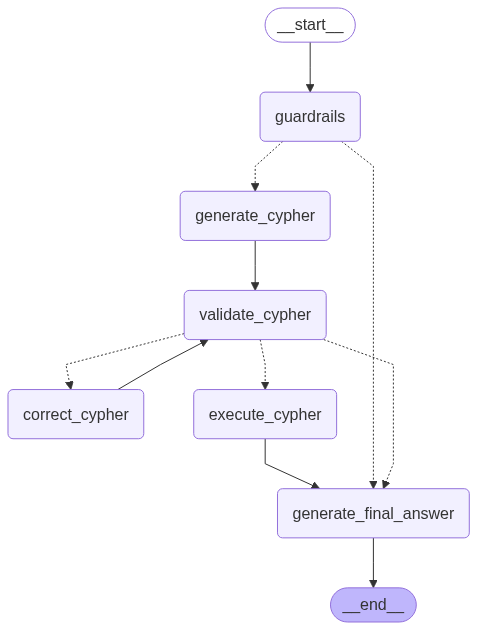

In [23]:
# 导入LangGraph相关模块
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph

# 创建状态图，定义输入和输出模式
langgraph = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)

# 添加各个处理节点
langgraph.add_node(guardrails)
langgraph.add_node(generate_cypher)
langgraph.add_node(validate_cypher)
langgraph.add_node(correct_cypher)
langgraph.add_node(execute_cypher)
langgraph.add_node(generate_final_answer)

# 配置图的边和条件边
langgraph.add_edge(START, "guardrails")
langgraph.add_conditional_edges(
    "guardrails",
    guardrails_condition,
)
langgraph.add_edge("generate_cypher", "validate_cypher")
langgraph.add_conditional_edges(
    "validate_cypher",
    validate_cypher_condition,
)
langgraph.add_edge("execute_cypher", "generate_final_answer")
langgraph.add_edge("correct_cypher", "validate_cypher")
langgraph.add_edge("generate_final_answer", END)

# 编译状态图
langgraph = langgraph.compile()

# 显示图形结构
display(Image(langgraph.get_graph().draw_mermaid_png()))

In [24]:
# 测试非电影相关问题（应该被守护机制拒绝）
langgraph.invoke({"question": "What's the weather in Spain?"})

{'answer': 'I cannot answer this question.',
 'steps': ['guardrail', 'generate_final_answer']}

In [25]:
# 测试电影相关问题（应该正常处理并返回结果）
langgraph.invoke({"question": "What was the cast of the Casino?"})

{'answer': 'The cast of "Casino" includes James Woods, Joe Pesci, Robert De Niro, and Sharon Stone.',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'execute_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (m:Movie {title: 'Casino'})<-[:ACTED_IN]-(a:Person) RETURN a.name"}